In [3]:
import pandas as pd
import ast
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import random
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(r'../data/interim/final_data_base.csv')
df.head()

,accession,date,organism,geographic_location,isolation_source,genetic_mechanisms,antibiogram
0,SAMN46923997,2025-02,neisseria gonorrhoeae,usa,rectal,none,"{'ciprofloxacin': 'intermediate', 'penicillin'..."
1,SAMN46841726,2025-02,klebsiella pneumoniae,brazil,blood,none,"{'cefotaxime': 'resistant', 'ceftazidime': 're..."
2,SAMN46841725,2025-02,klebsiella pneumoniae,brazil,blood,none,"{'cefotaxime': 'resistant', 'ceftazidime': 're..."
3,SAMN46841724,2025-02,klebsiella pneumoniae,brazil,blood,none,"{'cefotaxime': 'resistant', 'ceftazidime': 're..."
4,SAMN46841723,2025-02,klebsiella pneumoniae,brazil,ascitic fluid,none,"{'cefotaxime': 'resistant', 'ceftazidime': 're..."


# Pytorch Approach

In [5]:
def preprocess_nn_data_partial_ab(df, min_gene_freq=10, known_fraction=0.3, min_ab_support=50):

    def extract_gene_symbols(raw_str):
        try:
            items = ast.literal_eval(raw_str)
            return [item['Element symbol'] for item in items if isinstance(item, dict) and 'Element symbol' in item and isinstance(item['Element symbol'], str)]
        except Exception:
            return []

    def parse_antibiogram(raw_str):
        try:
            return ast.literal_eval(raw_str)
        except Exception:
            return {}

    # --- Gene vocab ---
    gene_counter = Counter()
    for row in df['genetic_mechanisms']:
        gene_list = extract_gene_symbols(row)
        gene_counter.update(gene_list)
    common_genes = [g for g, c in gene_counter.items() if c >= min_gene_freq]
    gene_vocab = {gene: idx + 1 for idx, gene in enumerate(sorted(common_genes))}  # 0 for padding

    # --- Build antibiotic support counts ---
    ab_counter = Counter()
    for row in df['antibiogram']:
        ab_dict = parse_antibiogram(row)
        ab_counter.update(k for k, v in ab_dict.items() if v in ['susceptible', 'intermediate', 'resistant'])

    filtered_antibiotics = sorted([ab for ab, count in ab_counter.items() if count >= min_ab_support])

    # --- Organism vocab ---
    organism_vocab = {org: i for i, org in enumerate(sorted(df['organism'].dropna().unique()))}

    # --- Row-wise processing ---
    records = []
    for _, row in df.iterrows():
        genes = extract_gene_symbols(row['genetic_mechanisms'])
        gene_ids = [gene_vocab[g] for g in genes if g in gene_vocab]

        ab_dict = parse_antibiogram(row['antibiogram'])
        available_abs = [ab for ab in ab_dict if ab in filtered_antibiotics]
        if not available_abs:
            continue  # skip if none of the antibiotics for this sample are in the filtered set

        num_known = max(1, int(len(available_abs) * known_fraction))
        known_ab = set(random.sample(available_abs, k=num_known))

        partial_vector = []
        target_vector = []
        mask_vector = []

        for ab in filtered_antibiotics:
            status = ab_dict.get(ab, None)
            if ab in known_ab:
                if status in ['susceptible', 'intermediate']:
                    partial_vector.append(1)
                elif status == 'resistant':
                    partial_vector.append(0)
                else:
                    partial_vector.append(-1)
                target_vector.append(-1)
                mask_vector.append(0)
            else:
                partial_vector.append(-1)
                if status in ['susceptible', 'intermediate']:
                    target_vector.append(1)
                    mask_vector.append(1)
                elif status == 'resistant':
                    target_vector.append(0)
                    mask_vector.append(1)
                else:
                    target_vector.append(-1)
                    mask_vector.append(0)

        organism_idx = organism_vocab.get(row['organism'], -1)
        records.append({
            'gene_ids': gene_ids,
            'organism_idx': organism_idx,
            'partial_ab_vector': partial_vector,
            'target_vector': target_vector,
            'mask_vector': mask_vector
        })

    df_final = pd.DataFrame(records)
    return df_final, gene_vocab, filtered_antibiotics, organism_vocab

In [6]:
# --- Dataset and Collate Function ---
class PartialABDataset(Dataset):
    def __init__(self, dataframe):
        self.samples = dataframe.to_dict('records')

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        gene_ids = torch.tensor(sample['gene_ids'], dtype=torch.long)
        org_idx = torch.tensor(sample['organism_idx'], dtype=torch.long)
        partial_ab = torch.tensor(sample['partial_ab_vector'], dtype=torch.float)
        target = torch.tensor(sample['target_vector'], dtype=torch.float)
        mask = torch.tensor(sample['mask_vector'], dtype=torch.bool)
        return gene_ids, org_idx, partial_ab, target, mask

def collate_fn_partial(batch):
    gene_ids, org_ids, partial_ab, targets, masks = zip(*batch)
    padded_genes = pad_sequence(gene_ids, batch_first=True, padding_value=0)
    org_ids = torch.stack(org_ids)
    partial_ab = torch.stack(partial_ab)
    targets = torch.stack(targets)
    masks = torch.stack(masks)
    return padded_genes, org_ids, partial_ab, targets, masks

# --- Model ---
class GeneOrganismABNN(nn.Module):
    def __init__(self, gene_vocab_size, organism_vocab_size, embedding_dim, ab_input_dim, hidden_dim, output_dim):
        super().__init__()
        self.gene_emb = nn.Embedding(gene_vocab_size + 1, embedding_dim, padding_idx=0)
        self.org_emb = nn.Embedding(organism_vocab_size + 1, embedding_dim)

        self.fc1 = nn.Linear(embedding_dim * 2 + ab_input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.output = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, gene_ids, org_idx, partial_ab):
        gene_embed = self.gene_emb(gene_ids).mean(dim=1)  # mean pooling
        org_embed = self.org_emb(org_idx)
        x = torch.cat([gene_embed, org_embed, partial_ab], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.output(x))

# --- Loss ---
def masked_bce_loss(preds, targets, mask):
    masked_preds = preds[mask]
    masked_targets = targets[mask]
    return nn.BCELoss()(masked_preds, masked_targets)

# --- Training ---
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for gene_ids, org_ids, partial_ab, targets, masks in tqdm(dataloader, desc="Training"):
        gene_ids, org_ids, partial_ab = gene_ids.to(device), org_ids.to(device), partial_ab.to(device)
        targets, masks = targets.to(device), masks.to(device)

        optimizer.zero_grad()
        preds = model(gene_ids, org_ids, partial_ab)
        loss = masked_bce_loss(preds, targets, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for gene_ids, org_ids, partial_ab, targets, masks in tqdm(dataloader, desc="Evaluating"):
            gene_ids, org_ids, partial_ab = gene_ids.to(device), org_ids.to(device), partial_ab.to(device)
            targets, masks = targets.to(device), masks.to(device)

            preds = model(gene_ids, org_ids, partial_ab)
            loss = masked_bce_loss(preds, targets, masks)
            total_loss += loss.item()
    return total_loss / len(dataloader)

# --- Collect Predictions for F1 ---
def collect_predictions(model, dataloader, device):
    model.eval()
    all_preds, all_labels, all_masks = [], [], []
    with torch.no_grad():
        for gene_ids, org_ids, partial_ab, targets, masks in dataloader:
            gene_ids, org_ids, partial_ab = gene_ids.to(device), org_ids.to(device), partial_ab.to(device)
            targets, masks = targets.to(device), masks.to(device)
            preds = model(gene_ids, org_ids, partial_ab)
            all_preds.append(preds.detach().cpu())
            all_labels.append(targets.detach().cpu())
            all_masks.append(masks.detach().cpu())
    return torch.cat(all_preds), torch.cat(all_labels), torch.cat(all_masks)

# --- F1 Computation ---
from sklearn.metrics import f1_score

def compute_f1(preds, labels, masks, threshold=0.5):
    preds_bin = (preds.numpy() >= threshold).astype(int)
    labels_np = labels.numpy()
    masks_np = masks.numpy()
    return f1_score(labels_np[masks_np], preds_bin[masks_np])

# --- Training Pipeline with Early Stopping + Logging ---
def run_training_pipeline(train_df, val_df, gene_vocab_size, organism_vocab_size, ab_input_dim, output_dim,
                          embedding_dim=64, hidden_dim=128, batch_size=32, epochs=50, lr=1e-3,
                          patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_ds = PartialABDataset(train_df)
    val_ds = PartialABDataset(val_df)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_partial)
    val_loader = DataLoader(val_ds, batch_size=batch_size, collate_fn=collate_fn_partial)

    model = GeneOrganismABNN(
        gene_vocab_size=gene_vocab_size,
        organism_vocab_size=organism_vocab_size,
        embedding_dim=embedding_dim,
        ab_input_dim=ab_input_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_f1 = 0
    best_model = deepcopy(model.state_dict())
    no_improve = 0

    train_losses = []
    val_losses = []
    val_f1_scores = []

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        val_loss = evaluate_model(model, val_loader, device)

        preds, labels, masks = collect_predictions(model, val_loader, device)
        val_f1 = compute_f1(preds, labels, masks)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, F1 = {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch}.")
                break

    model.load_state_dict(best_model)
    return model, train_losses, val_losses, val_f1_scores

In [7]:
df, gene_vocab, filtered_abx, organism_vocab = preprocess_nn_data_partial_ab(df, min_gene_freq=20, min_ab_support=50)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

model, train_losses, val_losses, val_f1_scores = run_training_pipeline(
    train_df=train_df,
    val_df=val_df,
    gene_vocab_size=len(gene_vocab),
    organism_vocab_size=len(organism_vocab),
    ab_input_dim=len(filtered_abx),
    output_dim=len(filtered_abx),
    epochs=50,            # max cap
    patience=5,           # stop if no improvement in 5 epochs
    lr=1e-3
)


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 283.44it/s]


Epoch 1: Train Loss = 0.3516, Val Loss = 0.3049, F1 = 0.9107


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 316.32it/s]


Epoch 2: Train Loss = 0.2832, Val Loss = 0.2851, F1 = 0.9211


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 302.78it/s]


Epoch 3: Train Loss = 0.2598, Val Loss = 0.2602, F1 = 0.9263


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 314.82it/s]


Epoch 4: Train Loss = 0.2451, Val Loss = 0.2501, F1 = 0.9305


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 317.95it/s]


Epoch 5: Train Loss = 0.2358, Val Loss = 0.2466, F1 = 0.9314


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 319.49it/s]


Epoch 6: Train Loss = 0.2294, Val Loss = 0.2395, F1 = 0.9336


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 292.16it/s]


Epoch 7: Train Loss = 0.2230, Val Loss = 0.2403, F1 = 0.9341


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 297.27it/s]


Epoch 8: Train Loss = 0.2181, Val Loss = 0.2413, F1 = 0.9343


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 256.16it/s]


Epoch 9: Train Loss = 0.2138, Val Loss = 0.2333, F1 = 0.9343


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 313.42it/s]


Epoch 10: Train Loss = 0.2103, Val Loss = 0.2339, F1 = 0.9362


Evaluating: 100%|██████████| 221/221 [00:01<00:00, 189.40it/s]


Epoch 11: Train Loss = 0.2073, Val Loss = 0.2309, F1 = 0.9372


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 322.66it/s]


Epoch 12: Train Loss = 0.2041, Val Loss = 0.2315, F1 = 0.9377


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 342.92it/s]


Epoch 13: Train Loss = 0.2010, Val Loss = 0.2345, F1 = 0.9359


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 335.17it/s]


Epoch 14: Train Loss = 0.1983, Val Loss = 0.2326, F1 = 0.9379


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 332.43it/s]


Epoch 15: Train Loss = 0.1958, Val Loss = 0.2348, F1 = 0.9370


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 295.47it/s]


Epoch 16: Train Loss = 0.1933, Val Loss = 0.2363, F1 = 0.9374


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 327.55it/s]


Epoch 17: Train Loss = 0.1907, Val Loss = 0.2314, F1 = 0.9375


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 308.17it/s]


Epoch 18: Train Loss = 0.1889, Val Loss = 0.2310, F1 = 0.9375


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 246.43it/s]


Epoch 19: Train Loss = 0.1868, Val Loss = 0.2314, F1 = 0.9386


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 335.55it/s]


Epoch 20: Train Loss = 0.1845, Val Loss = 0.2287, F1 = 0.9384


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 281.39it/s]


Epoch 21: Train Loss = 0.1819, Val Loss = 0.2320, F1 = 0.9399


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 310.81it/s]


Epoch 22: Train Loss = 0.1802, Val Loss = 0.2330, F1 = 0.9388


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 298.50it/s]


Epoch 23: Train Loss = 0.1784, Val Loss = 0.2336, F1 = 0.9394


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 299.72it/s]


Epoch 24: Train Loss = 0.1773, Val Loss = 0.2355, F1 = 0.9358


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 288.34it/s]


Epoch 25: Train Loss = 0.1754, Val Loss = 0.2382, F1 = 0.9390


Evaluating: 100%|██████████| 221/221 [00:00<00:00, 310.36it/s]


Epoch 26: Train Loss = 0.1726, Val Loss = 0.2377, F1 = 0.9390
Early stopping at epoch 26.


In [8]:
# --- Collect predictions and labels ---
def collect_predictions(model, dataloader, device, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []
    all_masks = []

    with torch.no_grad():
        for gene_ids, org_ids, partial_ab, targets, masks in dataloader:
            gene_ids, org_ids, partial_ab = gene_ids.to(device), org_ids.to(device), partial_ab.to(device)
            targets, masks = targets.to(device), masks.to(device)

            preds = model(gene_ids, org_ids, partial_ab)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(targets.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    preds = np.concatenate(all_preds, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    masks = np.concatenate(all_masks, axis=0)
    return preds, labels, masks

# --- Compute metrics ---
def compute_metrics(preds, labels, masks, threshold=0.5):
    binary_preds = (preds >= threshold).astype(int)
    y_true = labels[masks == 1].flatten()
    y_pred = binary_preds[masks == 1].flatten()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=False, zero_division=0)

    return acc, f1, report

# --- Confusion matrix for individual ABs (optional) ---
def per_antibiotic_scores(preds, labels, masks, ab_names, threshold=0.5):
    binary_preds = (preds >= threshold).astype(int)
    scores = {}
    for i, ab in enumerate(ab_names):
        mask_i = masks[:, i] == 1
        if mask_i.sum() == 0:
            continue
        y_true = labels[mask_i, i]
        y_pred = binary_preds[mask_i, i]
        scores[ab] = {
            'accuracy': accuracy_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred)
        }
    return scores

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

val_loader = DataLoader(PartialABDataset(val_df), batch_size=32, collate_fn=collate_fn_partial)

preds, labels, masks = collect_predictions(model, val_loader, device)
acc, f1, report = compute_metrics(preds, labels, masks)
print(report)

per_ab = per_antibiotic_scores(preds, labels, masks, filtered_abx)

              precision    recall  f1-score   support

         0.0       0.85      0.72      0.78     13441
         1.0       0.92      0.96      0.94     44444

    accuracy                           0.91     57885
   macro avg       0.88      0.84      0.86     57885
weighted avg       0.90      0.91      0.90     57885



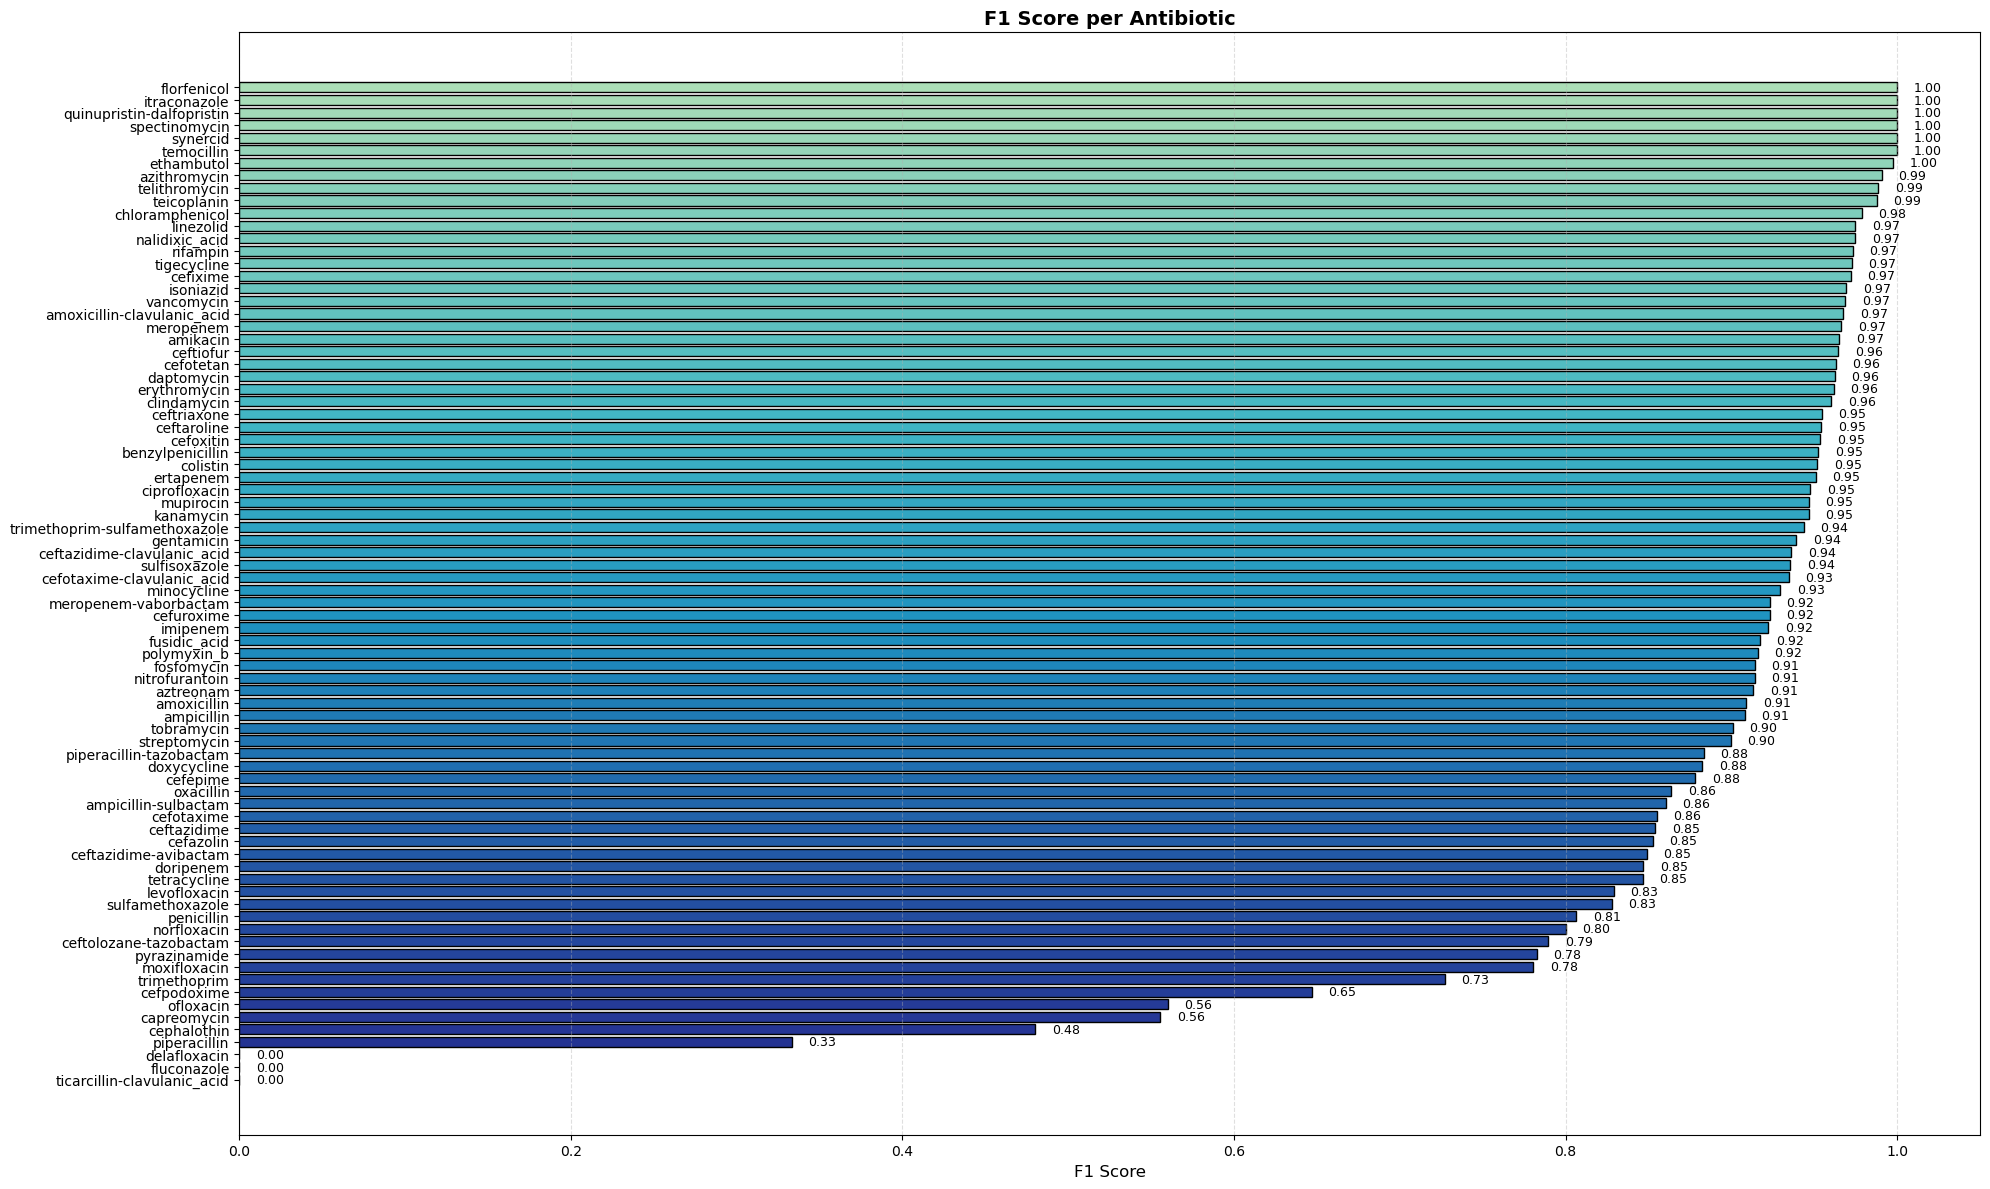

In [11]:
# Extract F1 scores from per_ab
ab_f1 = {ab: metrics['f1'] for ab, metrics in per_ab.items()}
sorted_ab = sorted(ab_f1.items(), key=lambda x: x[1], reverse=True)
labels, scores = zip(*sorted_ab)

# Assume per_ab is already defined
colors = plt.cm.YlGnBu(np.linspace(0.3, 0.9, len(scores)))  # soften the range

plt.figure(figsize=(20, 12))
bars = plt.barh(labels[::-1], scores[::-1], color=colors[::-1], edgecolor='black')
plt.xlabel("F1 Score", fontsize=12)
plt.title("F1 Score per Antibiotic", fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Annotate bars with F1 score
for bar, score in zip(bars, scores[::-1]):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f"{score:.2f}", va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

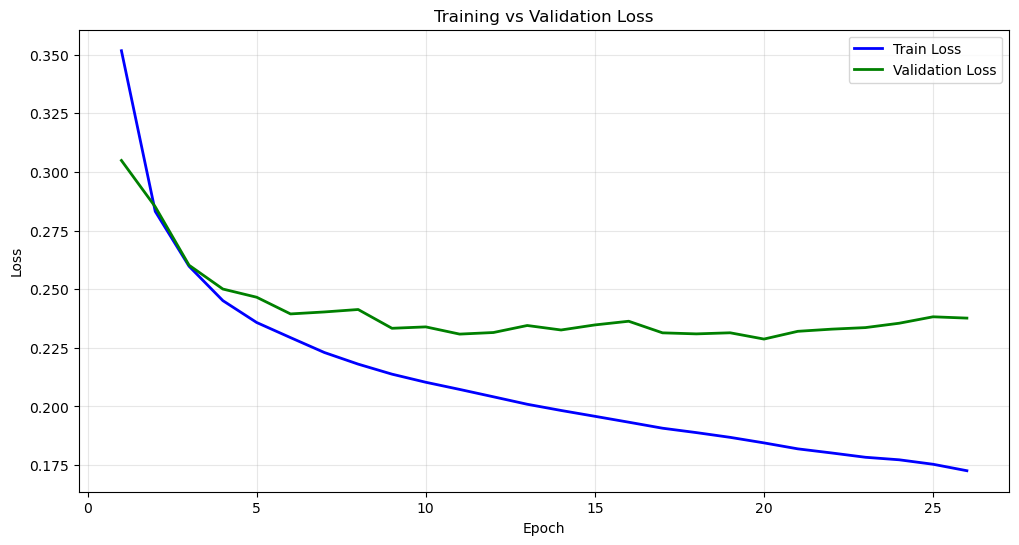

In [12]:
epochs = list(range(1, len(train_losses)+1))

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(epochs, val_losses, label='Validation Loss', color='green', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

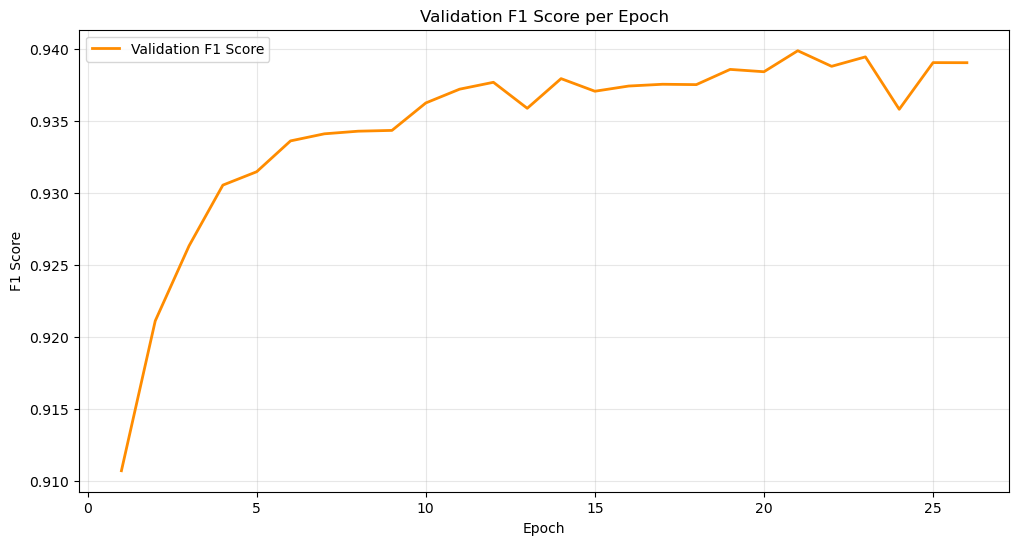

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_f1_scores, label='Validation F1 Score', color='darkorange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score per Epoch')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [43]:
from ab_protocol_map import AB_PROTOCOLS_GENERAL

TIER_WEIGHTS = {"first_line": 1.0, "second_line": 0.8, "reserve": 0.4, "unclassified": 0.5}

def recommend_antibiotics(gene_list, organism_name, known_antibiogram,
                          model, gene_vocab, organism_vocab, all_antibiotics,
                          threshold=0.5, max_per_tier=5):
    gene_embed_dim = model.gene_emb.num_embeddings
    gene_ids = [gene_vocab.get(g, 0) for g in gene_list]
    gene_ids = [idx if idx < gene_embed_dim else 0 for idx in gene_ids]
    if not gene_ids:
        gene_ids = [0]
    gene_tensor = torch.tensor([gene_ids], dtype=torch.long)

    org_embed_dim = model.org_emb.num_embeddings
    org_idx_value = organism_vocab.get(organism_name, 0)
    if org_idx_value >= org_embed_dim:
        org_idx_value = 0
    org_idx = torch.tensor([org_idx_value], dtype=torch.long)

    partial_ab_vector = []
    mask_vector = []
    for ab in all_antibiotics:
        status = known_antibiogram.get(ab, None)
        if status in ['susceptible', 'intermediate']:
            partial_ab_vector.append(1)
            mask_vector.append(0)
        elif status == 'resistant':
            partial_ab_vector.append(0)
            mask_vector.append(0)
        else:
            partial_ab_vector.append(-1)
            mask_vector.append(1)

    partial_ab_tensor = torch.tensor(partial_ab_vector, dtype=torch.float).unsqueeze(0)
    mask_tensor = torch.tensor(mask_vector, dtype=torch.bool).unsqueeze(0)

    device = next(model.parameters()).device
    gene_tensor = gene_tensor.to(device)
    org_idx = org_idx.to(device)
    partial_ab_tensor = partial_ab_tensor.to(device)

    model.eval()
    with torch.no_grad():
        preds = model(gene_tensor, org_idx, partial_ab_tensor).cpu().numpy().flatten()

    def get_tier(ab):
        for tier, ab_list in AB_PROTOCOLS_GENERAL.items():
            if ab in ab_list:
                return tier
        return "unclassified"

    recommendations_by_tier = {tier: [] for tier in TIER_WEIGHTS.keys()}
    for i, (ab, mask) in enumerate(zip(all_antibiotics, mask_vector)):
        if not mask:
            continue
        raw_score = preds[i]
        tier = get_tier(ab)
        weighted_score = raw_score * TIER_WEIGHTS.get(tier, 0.5)
        if weighted_score >= threshold:
            recommendations_by_tier[tier].append((ab, raw_score, tier, weighted_score))

    final_recommendations = []
    for tier, recs in recommendations_by_tier.items():
        recs.sort(key=lambda x: x[3], reverse=True)
        final_recommendations.extend(recs[:max_per_tier])

    final_recommendations.sort(key=lambda x: x[3], reverse=True)
    return final_recommendations

# --- Formatting Function ---
def format_recommendations(recommendations):
    formatted = []
    for ab, raw_score, tier, weighted_score in recommendations:
        formatted.append({
            "antibiotic": ab,
            "predicted_susceptibility": round(raw_score, 3),
            "tier": tier,
            "weighted_score": round(weighted_score, 3)
        })
    return formatted

# --- Report Function ---
def print_recommendation_report(recommendations):
    print("\n===== ANTIBIOTIC RECOMMENDATION REPORT =====\n")
    for ab, raw_score, tier, weighted_score in recommendations:
        print(f"{ab.title():<30} | Tier: {tier:<12} | Susceptibility: {raw_score:.2f} | Weighted Score: {weighted_score:.2f}")
    print("\n============================================\n")

In [44]:
recs = recommend_antibiotics(
     gene_list=['blaTEM', 'mtrR'],
     organism_name='E. coli',
     known_antibiogram={'ampicillin': 'resistant', 'gentamicin': 'susceptible'},
     model=model,
     gene_vocab=gene_vocab,
     organism_vocab=organism_vocab,
     all_antibiotics=filtered_abx,
     threshold=0.5)

print_recommendation_report(recs)


===== ANTIBIOTIC RECOMMENDATION REPORT =====

Cephalothin                    | Tier: first_line   | Susceptibility: 1.00 | Weighted Score: 1.00
Spectinomycin                  | Tier: first_line   | Susceptibility: 1.00 | Weighted Score: 1.00
Sulfamethoxazole               | Tier: first_line   | Susceptibility: 1.00 | Weighted Score: 1.00
Sulfisoxazole                  | Tier: first_line   | Susceptibility: 1.00 | Weighted Score: 1.00
Tobramycin                     | Tier: first_line   | Susceptibility: 1.00 | Weighted Score: 1.00
Ceftaroline                    | Tier: second_line  | Susceptibility: 1.00 | Weighted Score: 0.80
Ceftazidime                    | Tier: second_line  | Susceptibility: 1.00 | Weighted Score: 0.80
Colistin                       | Tier: second_line  | Susceptibility: 1.00 | Weighted Score: 0.80
Doxycycline                    | Tier: second_line  | Susceptibility: 1.00 | Weighted Score: 0.80
Linezolid                      | Tier: second_line  | Susceptibility: 1